In [512]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("DataFrameBasics").getOrCreate()

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import math
import plotly.express as px

from sklearn.cluster import KMeans


Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpa

In [513]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("DataFrameBasics").getOrCreate()

In [514]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [515]:
import pandas as pd
IMbd_ratings_df = pd.read_csv("/content/IMDb_ratings.csv")
IMbd_ratings_df 

,imdb_title_id,weighted_average_vote,total_votes,mean_vote,median_vote,votes_10,votes_9,votes_8,votes_7,votes_6,votes_5,votes_4,votes_3,votes_2,votes_1,allgenders_0age_avg_vote,allgenders_0age_votes,allgenders_18age_avg_vote,allgenders_18age_votes,allgenders_30age_avg_vote,allgenders_30age_votes,allgenders_45age_avg_vote,allgenders_45age_votes,males_allages_avg_vote,males_allages_votes,males_0age_avg_vote,males_0age_votes,males_18age_avg_vote,males_18age_votes,males_30age_avg_vote,males_30age_votes,males_45age_avg_vote,males_45age_votes,females_allages_avg_vote,females_allages_votes,females_0age_avg_vote,females_0age_votes,females_18age_avg_vote,females_18age_votes,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0000009,5.9,154,5.9,6.0,12,4,10,43,28,28,9,1,5,14,7.2,4.0,6.0,38.0,5.7,50.0,6.6,35.0,6.2,97.0,7.0,1.0,5.9,24.0,5.6,36.0,6.7,31.0,6.0,35.0,7.3,3.0,5.9,14.0,5.7,13.0,4.5,4.0,5.7,34.0,6.4,51.0,6.0,70.0
1,tt0000574,6.1,589,6.3,6.0,57,18,58,137,139,103,28,20,13,16,6.0,1.0,6.1,114.0,6.0,239.0,6.3,115.0,6.1,425.0,6.0,1.0,6.2,102.0,6.0,210.0,6.2,100.0,6.2,50.0,NaN,NaN,5.9,12.0,6.2,23.0,6.6,14.0,6.4,66.0,6.0,96.0,6.2,331.0
2,tt0001892,5.8,188,6.0,6.0,6,6,17,44,52,32,16,5,6,4,NaN,NaN,5.5,25.0,5.8,72.0,6.2,62.0,5.9,146.0,NaN,NaN,5.5,21.0,5.9,67.0,6.2,55.0,5.7,15.0,NaN,NaN,5.8,4.0,5.8,4.0,6.8,7.0,5.4,32.0,6.2,31.0,5.9,123.0
3,tt0002101,5.2,446,5.3,5.0,15,8,16,62,98,117,63,26,25,16,NaN,NaN,5.3,23.0,5.0,111.0,5.3,193.0,5.1,299.0,NaN,NaN,5.2,20.0,4.9,96.0,5.2,171.0,5.9,39.0,NaN,NaN,5.7,3.0,5.5,14.0,6.1,21.0,4.9,57.0,5.5,207.0,4.7,105.0
4,tt0002130,7.0,2237,6.9,7.0,210,225,436,641,344,169,66,39,20,87,7.5,4.0,7.0,402.0,7.0,895.0,7.1,482.0,7.0,1607.0,8.0,2.0,7.0,346.0,7.0,804.0,7.0,396.0,7.2,215.0,7.0,2.0,7.0,52.0,7.3,82.0,7.4,77.0,6.9,139.0,7.0,488.0,7.0,1166.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85850,tt9908390,5.3,398,5.5,6.0,13,9,26,65,104,86,32,28,15,20,6.0,1.0,5.8,42.0,5.3,137.0,5.2,101.0,5.3,267.0,6.0,1.0,5.6,28.0,5.3,121.0,5.2,97.0,6.0,26.0,NaN,NaN,6.2,11.0,5.7,11.0,5.0,2.0,5.5,12.0,6.3,22.0,5.3,214.0
85851,tt9911196,7.7,724,7.9,8.0,65,139,288,170,42,7,5,2,2,4,NaN,NaN,7.5,105.0,7.7,207.0,7.9,194.0,7.8,412.0,NaN,NaN,7.6,70.0,7.6,150.0,7.9,161.0,7.6,109.0,NaN,NaN,7.4,29.0,8.0,47.0,7.3,30.0,7.0,6.0,6.8,13.0,7.7,388.0
85852,tt9911774,7.9,265,7.8,8.0,63,29,61,61,31,5,5,6,1,3,NaN,NaN,1.0,1.0,10.0,1.0,3.0,1.0,6.0,4.0,NaN,NaN,1.0,1.0,10.0,1.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,2.0,2.0
85853,tt9914286,6.4,194,9.4,10.0,176,0,2,2,1,0,1,1,0,11,NaN,NaN,6.5,2.0,1.8,5.0,3.0,3.0,3.1,10.0,NaN,NaN,6.5,2.0,1.8,5.0,1.0,2.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1.0,4.0,3.0,1.7,5.0,5.8,5.0


In [516]:

import pandas as pd
movies1_df = pd.read_csv("/content/IMDb_movies1.csv")
movies1_df

,imdb_title_id,genre1,duration,country,language 1,avg_vote,votes,budget,reviews_from_users,reviews_from_critics
0,tt0000009,Romance,45,USA,None,5.9,154,NaN,1.0,2.0
1,tt0000574,Biography,70,Australia,None,6.1,589,"$2,250",7.0,7.0
2,tt0001892,Drama,53,USA,English,5.8,188,NaN,5.0,2.0
3,tt0002101,Adventure,100,Italy,Italian,5.2,446,"$45,000",25.0,3.0
4,tt0002130,Biography,68,USA,English,7.0,2237,NaN,31.0,14.0
...,...,...,...,...,...,...,...,...,...,...
85850,tt9908390,NaN,95,NaN,NaN,5.3,398,NaN,NaN,4.0
85851,tt9911196,NaN,103,NaN,NaN,7.7,724,NaN,6.0,4.0
85852,tt9911774,NaN,130,NaN,NaN,7.9,265,NaN,NaN,NaN
85853,tt9914286,NaN,98,NaN,NaN,6.4,194,NaN,NaN,NaN


In [517]:
#IMbd_ratings_df = IMbd_ratings_df.toPandas()
#IMbd_ratings_df

In [518]:
#Selecting relevant data from IMDb_ratings
clean_ratings_df = IMbd_ratings_df[["imdb_title_id",
                             "weighted_average_vote",
                             "total_votes",
                             "allgenders_0age_votes",
                             "allgenders_18age_votes",
                             "allgenders_30age_votes",
                             "allgenders_45age_votes",
                             "males_allages_votes",
                             "females_allages_votes"]]
clean_ratings_df.head()

,imdb_title_id,weighted_average_vote,total_votes,allgenders_0age_votes,allgenders_18age_votes,allgenders_30age_votes,allgenders_45age_votes,males_allages_votes,females_allages_votes
0,tt0000009,5.9,154,4.0,38.0,50.0,35.0,97.0,35.0
1,tt0000574,6.1,589,1.0,114.0,239.0,115.0,425.0,50.0
2,tt0001892,5.8,188,NaN,25.0,72.0,62.0,146.0,15.0
3,tt0002101,5.2,446,NaN,23.0,111.0,193.0,299.0,39.0
4,tt0002130,7.0,2237,4.0,402.0,895.0,482.0,1607.0,215.0


In [519]:
#renaming headers in ratings data to avoid confusion
new_names = {"allgenders_0age_votes":"tot_voters_below_18",
            "allgenders_18age_votes":"tot_voters_below_30",
            "allgenders_30age_votes":"tot_voters_below_45",
            "allgenders_45age_votes" : "tot_voters_above_45",
            "males_allages_votes":"tot_male_voters",
             "females_allages_votes": "tot_female_voters"}
ratings_df = clean_ratings_df.rename(columns=new_names)
ratings_df.head(5)

,imdb_title_id,weighted_average_vote,total_votes,tot_voters_below_18,tot_voters_below_30,tot_voters_below_45,tot_voters_above_45,tot_male_voters,tot_female_voters
0,tt0000009,5.9,154,4.0,38.0,50.0,35.0,97.0,35.0
1,tt0000574,6.1,589,1.0,114.0,239.0,115.0,425.0,50.0
2,tt0001892,5.8,188,NaN,25.0,72.0,62.0,146.0,15.0
3,tt0002101,5.2,446,NaN,23.0,111.0,193.0,299.0,39.0
4,tt0002130,7.0,2237,4.0,402.0,895.0,482.0,1607.0,215.0


In [520]:
imdb_data_df = pd.merge(movies1_df,ratings_df, on="imdb_title_id", how="outer")
imdb_data_df.head()

,imdb_title_id,genre1,duration,country,language 1,avg_vote,votes,budget,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,tot_voters_below_18,tot_voters_below_30,tot_voters_below_45,tot_voters_above_45,tot_male_voters,tot_female_voters
0,tt0000009,Romance,45,USA,None,5.9,154,NaN,1.0,2.0,5.9,154,4.0,38.0,50.0,35.0,97.0,35.0
1,tt0000574,Biography,70,Australia,None,6.1,589,"$2,250",7.0,7.0,6.1,589,1.0,114.0,239.0,115.0,425.0,50.0
2,tt0001892,Drama,53,USA,English,5.8,188,NaN,5.0,2.0,5.8,188,NaN,25.0,72.0,62.0,146.0,15.0
3,tt0002101,Adventure,100,Italy,Italian,5.2,446,"$45,000",25.0,3.0,5.2,446,NaN,23.0,111.0,193.0,299.0,39.0
4,tt0002130,Biography,68,USA,English,7.0,2237,NaN,31.0,14.0,7.0,2237,4.0,402.0,895.0,482.0,1607.0,215.0


In [521]:
#total null values in each column
imdb_data_df.isnull().sum()

imdb_title_id                0
genre1                    1712
duration                     0
country                   1712
language 1                1712
avg_vote                     0
votes                        0
budget                   62145
reviews_from_users        7597
reviews_from_critics     11797
weighted_average_vote        0
total_votes                  0
tot_voters_below_18      52496
tot_voters_below_30        706
tot_voters_below_45         10
tot_voters_above_45         80
tot_male_voters              1
tot_female_voters           81
dtype: int64

In [522]:
#Combining under 18 and under 30 columns to reduce null values in tot_voters_below_18 column
below_18 = imdb_data_df["tot_voters_below_18"]
below_30 = imdb_data_df["tot_voters_below_30"]

combined = []

#Initiating for loop to add values in below 18 and below 30 columns 
#Appending it to combined list to replace both columns by combined

for i in range(len(imdb_data_df)):
    if math.isnan(below_18[i]) is True & math.isnan(below_30[i]) is True:
        combined.append(below_18[i] + below_30[i])
        

    elif math.isnan(below_18[i]) is True and math.isnan(below_30[i]) is False:
        combined.append(below_30[i])
            
    elif math.isnan(below_18[i]) == False and math.isnan(below_30[i]) == True:
        combined.append(below_18[i])
            
    else:
        combined.append(0)

In [523]:
# Dropping under 18 columns
imdb_data_df = imdb_data_df.drop("tot_voters_below_18", axis = 1)

# Repacing under 18 and under 30 columns by under 30(combined)
imdb_data_df["tot_voters_below_18"] = combined

In [524]:
#dropping empty values
imdb_data_df = imdb_data_df.dropna()
imdb_data_df 

,imdb_title_id,genre1,duration,country,language 1,avg_vote,votes,budget,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,tot_voters_below_30,tot_voters_below_45,tot_voters_above_45,tot_male_voters,tot_female_voters,tot_voters_below_18
1,tt0000574,Biography,70,Australia,None,6.1,589,"$2,250",7.0,7.0,6.1,589,114.0,239.0,115.0,425.0,50.0,0.0
3,tt0002101,Adventure,100,Italy,Italian,5.2,446,"$45,000",25.0,3.0,5.2,446,23.0,111.0,193.0,299.0,39.0,23.0
7,tt0002445,Drama,120,"France, USA",English,6.2,273,ITL 45000,7.0,5.0,6.2,273,34.0,99.0,69.0,191.0,21.0,0.0
8,tt0002452,Drama,120,Denmark,Danish,6.7,198,ROL 400000,4.0,1.0,6.7,198,28.0,104.0,39.0,153.0,19.0,28.0
9,tt0002461,Crime,55,France,French,5.5,225,"$30,000",8.0,1.0,5.5,225,11.0,95.0,72.0,168.0,15.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84118,tt8350360,Comedy,106,"Mexico, Chile",Spanish,5.9,53649,"$30,000,000",748.0,229.0,5.9,53649,12616.0,16561.0,3887.0,28834.0,6720.0,0.0
84124,tt8354006,Drama,90,Bangladesh,Bengali,5.9,400,"$1,000,000",19.0,2.0,5.9,400,35.0,112.0,122.0,130.0,153.0,35.0
84129,tt8355636,Action,80,USA,English,6.6,177,UAH 16000000,3.0,1.0,6.6,177,39.0,72.0,14.0,106.0,24.0,39.0
84132,tt8358682,Animation,91,Japan,Japanese,2.9,345,"$20,000,000",18.0,2.0,2.9,345,17.0,74.0,113.0,214.0,16.0,17.0


In [525]:
imdb_data_df 

,imdb_title_id,genre1,duration,country,language 1,avg_vote,votes,budget,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,tot_voters_below_30,tot_voters_below_45,tot_voters_above_45,tot_male_voters,tot_female_voters,tot_voters_below_18
1,tt0000574,Biography,70,Australia,None,6.1,589,"$2,250",7.0,7.0,6.1,589,114.0,239.0,115.0,425.0,50.0,0.0
3,tt0002101,Adventure,100,Italy,Italian,5.2,446,"$45,000",25.0,3.0,5.2,446,23.0,111.0,193.0,299.0,39.0,23.0
7,tt0002445,Drama,120,"France, USA",English,6.2,273,ITL 45000,7.0,5.0,6.2,273,34.0,99.0,69.0,191.0,21.0,0.0
8,tt0002452,Drama,120,Denmark,Danish,6.7,198,ROL 400000,4.0,1.0,6.7,198,28.0,104.0,39.0,153.0,19.0,28.0
9,tt0002461,Crime,55,France,French,5.5,225,"$30,000",8.0,1.0,5.5,225,11.0,95.0,72.0,168.0,15.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84118,tt8350360,Comedy,106,"Mexico, Chile",Spanish,5.9,53649,"$30,000,000",748.0,229.0,5.9,53649,12616.0,16561.0,3887.0,28834.0,6720.0,0.0
84124,tt8354006,Drama,90,Bangladesh,Bengali,5.9,400,"$1,000,000",19.0,2.0,5.9,400,35.0,112.0,122.0,130.0,153.0,35.0
84129,tt8355636,Action,80,USA,English,6.6,177,UAH 16000000,3.0,1.0,6.6,177,39.0,72.0,14.0,106.0,24.0,39.0
84132,tt8358682,Animation,91,Japan,Japanese,2.9,345,"$20,000,000",18.0,2.0,2.9,345,17.0,74.0,113.0,214.0,16.0,17.0


In [526]:
Clean_imdb_data_df = imdb_data_df.drop(["imdb_title_id"],1)
Clean_imdb_data_df

,genre1,duration,country,language 1,avg_vote,votes,budget,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,tot_voters_below_30,tot_voters_below_45,tot_voters_above_45,tot_male_voters,tot_female_voters,tot_voters_below_18
1,Biography,70,Australia,None,6.1,589,"$2,250",7.0,7.0,6.1,589,114.0,239.0,115.0,425.0,50.0,0.0
3,Adventure,100,Italy,Italian,5.2,446,"$45,000",25.0,3.0,5.2,446,23.0,111.0,193.0,299.0,39.0,23.0
7,Drama,120,"France, USA",English,6.2,273,ITL 45000,7.0,5.0,6.2,273,34.0,99.0,69.0,191.0,21.0,0.0
8,Drama,120,Denmark,Danish,6.7,198,ROL 400000,4.0,1.0,6.7,198,28.0,104.0,39.0,153.0,19.0,28.0
9,Crime,55,France,French,5.5,225,"$30,000",8.0,1.0,5.5,225,11.0,95.0,72.0,168.0,15.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84118,Comedy,106,"Mexico, Chile",Spanish,5.9,53649,"$30,000,000",748.0,229.0,5.9,53649,12616.0,16561.0,3887.0,28834.0,6720.0,0.0
84124,Drama,90,Bangladesh,Bengali,5.9,400,"$1,000,000",19.0,2.0,5.9,400,35.0,112.0,122.0,130.0,153.0,35.0
84129,Action,80,USA,English,6.6,177,UAH 16000000,3.0,1.0,6.6,177,39.0,72.0,14.0,106.0,24.0,39.0
84132,Animation,91,Japan,Japanese,2.9,345,"$20,000,000",18.0,2.0,2.9,345,17.0,74.0,113.0,214.0,16.0,17.0


In [527]:
Clean_imdb_data_df = imdb_data_df.drop_duplicates()
Clean_imdb_data_df 

,imdb_title_id,genre1,duration,country,language 1,avg_vote,votes,budget,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,tot_voters_below_30,tot_voters_below_45,tot_voters_above_45,tot_male_voters,tot_female_voters,tot_voters_below_18
1,tt0000574,Biography,70,Australia,None,6.1,589,"$2,250",7.0,7.0,6.1,589,114.0,239.0,115.0,425.0,50.0,0.0
3,tt0002101,Adventure,100,Italy,Italian,5.2,446,"$45,000",25.0,3.0,5.2,446,23.0,111.0,193.0,299.0,39.0,23.0
7,tt0002445,Drama,120,"France, USA",English,6.2,273,ITL 45000,7.0,5.0,6.2,273,34.0,99.0,69.0,191.0,21.0,0.0
8,tt0002452,Drama,120,Denmark,Danish,6.7,198,ROL 400000,4.0,1.0,6.7,198,28.0,104.0,39.0,153.0,19.0,28.0
9,tt0002461,Crime,55,France,French,5.5,225,"$30,000",8.0,1.0,5.5,225,11.0,95.0,72.0,168.0,15.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84118,tt8350360,Comedy,106,"Mexico, Chile",Spanish,5.9,53649,"$30,000,000",748.0,229.0,5.9,53649,12616.0,16561.0,3887.0,28834.0,6720.0,0.0
84124,tt8354006,Drama,90,Bangladesh,Bengali,5.9,400,"$1,000,000",19.0,2.0,5.9,400,35.0,112.0,122.0,130.0,153.0,35.0
84129,tt8355636,Action,80,USA,English,6.6,177,UAH 16000000,3.0,1.0,6.6,177,39.0,72.0,14.0,106.0,24.0,39.0
84132,tt8358682,Animation,91,Japan,Japanese,2.9,345,"$20,000,000",18.0,2.0,2.9,345,17.0,74.0,113.0,214.0,16.0,17.0


In [528]:
Clean_imdb_data_df.dtypes


imdb_title_id             object
genre1                    object
duration                   int64
country                   object
language 1                object
avg_vote                 float64
votes                      int64
budget                    object
reviews_from_users       float64
reviews_from_critics     float64
weighted_average_vote    float64
total_votes                int64
tot_voters_below_30      float64
tot_voters_below_45      float64
tot_voters_above_45      float64
tot_male_voters          float64
tot_female_voters        float64
tot_voters_below_18      float64
dtype: object

In [529]:
print(f"Duplicates entries: {Clean_imdb_data_df.duplicated().sum()}")

Duplicates entries: 0


In [530]:
Clean_imdb_data_df1 = imdb_data_df.drop(["imdb_title_id","budget"],1)
Clean_imdb_data_df1

,genre1,duration,country,language 1,avg_vote,votes,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,tot_voters_below_30,tot_voters_below_45,tot_voters_above_45,tot_male_voters,tot_female_voters,tot_voters_below_18
1,Biography,70,Australia,None,6.1,589,7.0,7.0,6.1,589,114.0,239.0,115.0,425.0,50.0,0.0
3,Adventure,100,Italy,Italian,5.2,446,25.0,3.0,5.2,446,23.0,111.0,193.0,299.0,39.0,23.0
7,Drama,120,"France, USA",English,6.2,273,7.0,5.0,6.2,273,34.0,99.0,69.0,191.0,21.0,0.0
8,Drama,120,Denmark,Danish,6.7,198,4.0,1.0,6.7,198,28.0,104.0,39.0,153.0,19.0,28.0
9,Crime,55,France,French,5.5,225,8.0,1.0,5.5,225,11.0,95.0,72.0,168.0,15.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84118,Comedy,106,"Mexico, Chile",Spanish,5.9,53649,748.0,229.0,5.9,53649,12616.0,16561.0,3887.0,28834.0,6720.0,0.0
84124,Drama,90,Bangladesh,Bengali,5.9,400,19.0,2.0,5.9,400,35.0,112.0,122.0,130.0,153.0,35.0
84129,Action,80,USA,English,6.6,177,3.0,1.0,6.6,177,39.0,72.0,14.0,106.0,24.0,39.0
84132,Animation,91,Japan,Japanese,2.9,345,18.0,2.0,2.9,345,17.0,74.0,113.0,214.0,16.0,17.0


In [531]:
Clean_imdb_data_df1 = Clean_imdb_data_df1.dropna()
Clean_imdb_data_df1 

,genre1,duration,country,language 1,avg_vote,votes,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,tot_voters_below_30,tot_voters_below_45,tot_voters_above_45,tot_male_voters,tot_female_voters,tot_voters_below_18
1,Biography,70,Australia,None,6.1,589,7.0,7.0,6.1,589,114.0,239.0,115.0,425.0,50.0,0.0
3,Adventure,100,Italy,Italian,5.2,446,25.0,3.0,5.2,446,23.0,111.0,193.0,299.0,39.0,23.0
7,Drama,120,"France, USA",English,6.2,273,7.0,5.0,6.2,273,34.0,99.0,69.0,191.0,21.0,0.0
8,Drama,120,Denmark,Danish,6.7,198,4.0,1.0,6.7,198,28.0,104.0,39.0,153.0,19.0,28.0
9,Crime,55,France,French,5.5,225,8.0,1.0,5.5,225,11.0,95.0,72.0,168.0,15.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84118,Comedy,106,"Mexico, Chile",Spanish,5.9,53649,748.0,229.0,5.9,53649,12616.0,16561.0,3887.0,28834.0,6720.0,0.0
84124,Drama,90,Bangladesh,Bengali,5.9,400,19.0,2.0,5.9,400,35.0,112.0,122.0,130.0,153.0,35.0
84129,Action,80,USA,English,6.6,177,3.0,1.0,6.6,177,39.0,72.0,14.0,106.0,24.0,39.0
84132,Animation,91,Japan,Japanese,2.9,345,18.0,2.0,2.9,345,17.0,74.0,113.0,214.0,16.0,17.0


In [532]:
#Clean_imdb_data_df1.groupby("language")

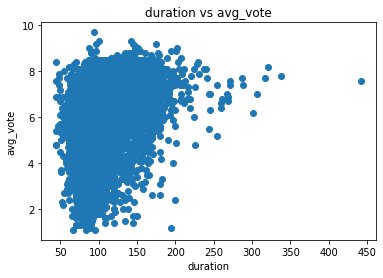

In [533]:
import matplotlib.pyplot as plt
duration = Clean_imdb_data_df1 ['duration'].tolist()
avg_vote = Clean_imdb_data_df1 ['avg_vote'].tolist()
plt.scatter(duration,avg_vote)
plt.title('duration vs avg_vote')
plt.xlabel('duration')
plt.ylabel('avg_vote')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 9 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 9 missing from current font.



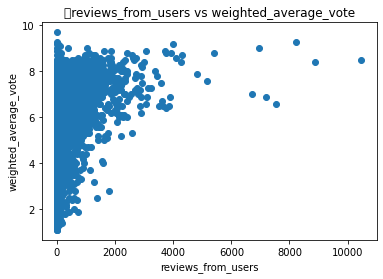

In [534]:
import matplotlib.pyplot as plt
reviews_from_users = Clean_imdb_data_df1 ['reviews_from_users'].tolist()
weighted_average_vote = Clean_imdb_data_df1 ['weighted_average_vote'].tolist()
plt.scatter(reviews_from_users,weighted_average_vote)
plt.title('	reviews_from_users vs weighted_average_vote')
plt.xlabel('reviews_from_users')
plt.ylabel('weighted_average_vote')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 9 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 9 missing from current font.



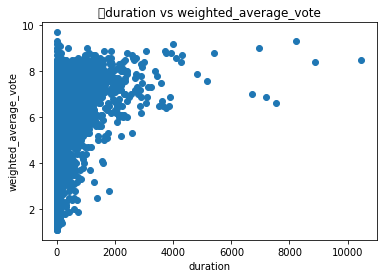

In [535]:
import matplotlib.pyplot as plt
duration = Clean_imdb_data_df1 ['duration'].tolist()
weighted_average_vote = Clean_imdb_data_df1 ['weighted_average_vote'].tolist()
plt.scatter(reviews_from_users,weighted_average_vote)
plt.title('	duration vs weighted_average_vote')
plt.xlabel('duration')
plt.ylabel('weighted_average_vote')
plt.show()

In [536]:
# Determine the number of unique values in each column.
ratings_cat = Clean_imdb_data_df1.dtypes[Clean_imdb_data_df1.dtypes == "object"].index.tolist()
ratings_cat 

['genre1', 'country', 'language 1']

In [537]:
Clean_imdb_data_df1[ratings_cat ].nunique()

genre1          21
country       1829
language 1     121
dtype: int64

In [539]:
# Look at duration value counts for binning
genre1 = Clean_imdb_data_df1.genre1.value_counts()
genre1

Drama        6236
Comedy       5797
Action       3051
Horror       1297
Crime        1282
Adventure     821
Animation     534
Biography     532
Thriller      342
Romance       167
Family        157
Mystery       139
Western       124
Fantasy       115
Sci-Fi        110
Musical        64
War            22
Music          22
History        18
Film-Noir       3
Sport           2
Name: genre1, dtype: int64

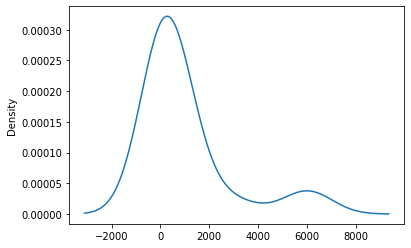

In [540]:
# Visualize the value counts of genre
genre1.plot.density()

In [542]:
# Determine which values to replace if counts are less than ...?
replace_genre1 = list(genre1 [genre1 < 500].index)

# Replace in dataframe
for app in replace_genre1:
      Clean_imdb_data_df1.genre1 = Clean_imdb_data_df1.genre1.replace(app,"Other")
    
# Check to make sure binning was successful
Clean_imdb_data_df1.genre1.value_counts()

Drama        6236
Comedy       5797
Action       3051
Horror       1297
Other        1285
Crime        1282
Adventure     821
Animation     534
Biography     532
Name: genre1, dtype: int64

In [543]:
# Look at duration value counts for binning
duration = Clean_imdb_data_df1.duration.value_counts()
duration

90     1107
95      738
100     705
92      597
93      575
       ... 
321       1
442       1
271       1
338       1
287       1
Name: duration, Length: 195, dtype: int64

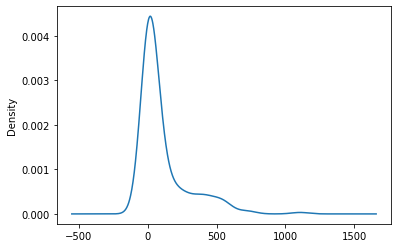

In [545]:
# Visualize the value counts of duration
duration.plot.density()

In [546]:
# Determine which values to replace if counts are less than ...?
replace_duration = list(duration [duration < 500].index)

# Replace in dataframe
for app in replace_duration:
      Clean_imdb_data_df1.duration = Clean_imdb_data_df1.duration.replace(app,"Other")
    
# Check to make sure binning was successful
Clean_imdb_data_df.duration.value_counts()

90     1107
95      738
100     705
92      597
93      575
       ... 
321       1
442       1
271       1
338       1
287       1
Name: duration, Length: 195, dtype: int64

In [547]:
country = Clean_imdb_data_df1.country.value_counts()
country

USA                            6766
India                          1491
UK                              919
France                          731
Japan                           707
                               ... 
Poland, France, UK                1
Luxembourg, Switzerland, UK       1
Germany, Turkey                   1
UK, France, USA, Belgium          1
USA, UK, Brazil                   1
Name: country, Length: 1829, dtype: int64

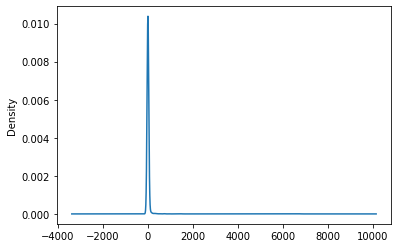

In [548]:
# Visualize the value counts of duration
country.plot.density()

In [549]:
# Determine which values to replace if counts are less than ...?
replace_country = list(country [country < 500].index)

# Replace in dataframe
for app in replace_country:
      Clean_imdb_data_df1.country = Clean_imdb_data_df1.country.replace(app,"Other")
    
# Check to make sure binning was successful
Clean_imdb_data_df1.country.value_counts()

Other     9678
USA       6766
India     1491
UK         919
France     731
Japan      707
Italy      543
Name: country, dtype: int64

In [550]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(Clean_imdb_data_df1[ratings_cat]))
# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(ratings_cat)
encode_df.head()

,genre1_Action,genre1_Adventure,genre1_Animation,genre1_Biography,genre1_Comedy,genre1_Crime,genre1_Drama,genre1_Horror,genre1_Other,country_France,country_India,country_Italy,country_Japan,country_Other,country_UK,country_USA,language 1_Aboriginal,language 1_Afrikaans,language 1_Albanian,language 1_American Sign Language,language 1_Amharic,language 1_Arabic,language 1_Aramaic,language 1_Armenian,language 1_Azerbaijani,language 1_Bambara,language 1_Basque,language 1_Belarusian,language 1_Bengali,language 1_Bosnian,language 1_Brazilian Sign Language,language 1_Bulgarian,language 1_Burmese,language 1_Cantonese,language 1_Catalan,language 1_Chinese,language 1_Crimean Tatar,language 1_Croatian,language 1_Czech,language 1_Danish,...,language 1_Polish,language 1_Portuguese,language 1_Pular,language 1_Punjabi,language 1_Pushto,language 1_Romanian,language 1_Romany,language 1_Rotuman,language 1_Russian,language 1_Saami,language 1_Samoan,language 1_Scanian,language 1_Serbian,language 1_Serbo-Croatian,language 1_Sign Languages,language 1_Sinhalese,language 1_Slovak,language 1_Slovenian,language 1_Southern Sotho,language 1_Spanish,language 1_Swedish,language 1_Swiss German,language 1_Tagalog,language 1_Tajik,language 1_Tamil,language 1_Telugu,language 1_Thai,language 1_Tigrigna,language 1_Tupi,language 1_Turkish,language 1_Ukrainian,language 1_Urdu,language 1_Uzbek,language 1_Vietnamese,language 1_Welsh,language 1_Wolof,language 1_Xhosa,language 1_Yiddish,language 1_Yoruba,language 1_Zulu
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [551]:
# Merge one-hot encoded features and drop the originals
Clean_imdb_data_df1 = Clean_imdb_data_df1.merge(encode_df,left_index=True, right_index=True)
Clean_imdb_data_df1 = Clean_imdb_data_df1.drop(ratings_cat,1)
Clean_imdb_data_df1.head()

,duration,avg_vote,votes,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,tot_voters_below_30,tot_voters_below_45,tot_voters_above_45,tot_male_voters,tot_female_voters,tot_voters_below_18,genre1_Action,genre1_Adventure,genre1_Animation,genre1_Biography,genre1_Comedy,genre1_Crime,genre1_Drama,genre1_Horror,genre1_Other,country_France,country_India,country_Italy,country_Japan,country_Other,country_UK,country_USA,language 1_Aboriginal,language 1_Afrikaans,language 1_Albanian,language 1_American Sign Language,language 1_Amharic,language 1_Arabic,language 1_Aramaic,language 1_Armenian,language 1_Azerbaijani,language 1_Bambara,language 1_Basque,...,language 1_Polish,language 1_Portuguese,language 1_Pular,language 1_Punjabi,language 1_Pushto,language 1_Romanian,language 1_Romany,language 1_Rotuman,language 1_Russian,language 1_Saami,language 1_Samoan,language 1_Scanian,language 1_Serbian,language 1_Serbo-Croatian,language 1_Sign Languages,language 1_Sinhalese,language 1_Slovak,language 1_Slovenian,language 1_Southern Sotho,language 1_Spanish,language 1_Swedish,language 1_Swiss German,language 1_Tagalog,language 1_Tajik,language 1_Tamil,language 1_Telugu,language 1_Thai,language 1_Tigrigna,language 1_Tupi,language 1_Turkish,language 1_Ukrainian,language 1_Urdu,language 1_Uzbek,language 1_Vietnamese,language 1_Welsh,language 1_Wolof,language 1_Xhosa,language 1_Yiddish,language 1_Yoruba,language 1_Zulu
1,Other,6.1,589,7.0,7.0,6.1,589,114.0,239.0,115.0,425.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100,5.2,446,25.0,3.0,5.2,446,23.0,111.0,193.0,299.0,39.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Other,6.2,273,7.0,5.0,6.2,273,34.0,99.0,69.0,191.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Other,6.7,198,4.0,1.0,6.7,198,28.0,104.0,39.0,153.0,19.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Other,5.5,225,8.0,1.0,5.5,225,11.0,95.0,72.0,168.0,15.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [552]:
Clean_imdb_data_df1

,duration,avg_vote,votes,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,tot_voters_below_30,tot_voters_below_45,tot_voters_above_45,tot_male_voters,tot_female_voters,tot_voters_below_18,genre1_Action,genre1_Adventure,genre1_Animation,genre1_Biography,genre1_Comedy,genre1_Crime,genre1_Drama,genre1_Horror,genre1_Other,country_France,country_India,country_Italy,country_Japan,country_Other,country_UK,country_USA,language 1_Aboriginal,language 1_Afrikaans,language 1_Albanian,language 1_American Sign Language,language 1_Amharic,language 1_Arabic,language 1_Aramaic,language 1_Armenian,language 1_Azerbaijani,language 1_Bambara,language 1_Basque,...,language 1_Polish,language 1_Portuguese,language 1_Pular,language 1_Punjabi,language 1_Pushto,language 1_Romanian,language 1_Romany,language 1_Rotuman,language 1_Russian,language 1_Saami,language 1_Samoan,language 1_Scanian,language 1_Serbian,language 1_Serbo-Croatian,language 1_Sign Languages,language 1_Sinhalese,language 1_Slovak,language 1_Slovenian,language 1_Southern Sotho,language 1_Spanish,language 1_Swedish,language 1_Swiss German,language 1_Tagalog,language 1_Tajik,language 1_Tamil,language 1_Telugu,language 1_Thai,language 1_Tigrigna,language 1_Tupi,language 1_Turkish,language 1_Ukrainian,language 1_Urdu,language 1_Uzbek,language 1_Vietnamese,language 1_Welsh,language 1_Wolof,language 1_Xhosa,language 1_Yiddish,language 1_Yoruba,language 1_Zulu
1,Other,6.1,589,7.0,7.0,6.1,589,114.0,239.0,115.0,425.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100,5.2,446,25.0,3.0,5.2,446,23.0,111.0,193.0,299.0,39.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Other,6.2,273,7.0,5.0,6.2,273,34.0,99.0,69.0,191.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Other,6.7,198,4.0,1.0,6.7,198,28.0,104.0,39.0,153.0,19.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Other,5.5,225,8.0,1.0,5.5,225,11.0,95.0,72.0,168.0,15.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20813,94,7.9,127692,511.0,124.0,7.9,127692,14658.0,54064.0,26672.0,77636.0,20933.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20829,Other,5.5,172,7.0,5.0,5.5,172,14.0,46.0,80.0,120.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,

In [553]:
Clean_imdb_data_df1 = pd.get_dummies(Clean_imdb_data_df1,columns =['duration'] )
Clean_imdb_data_df1

,avg_vote,votes,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,tot_voters_below_30,tot_voters_below_45,tot_voters_above_45,tot_male_voters,tot_female_voters,tot_voters_below_18,genre1_Action,genre1_Adventure,genre1_Animation,genre1_Biography,genre1_Comedy,genre1_Crime,genre1_Drama,genre1_Horror,genre1_Other,country_France,country_India,country_Italy,country_Japan,country_Other,country_UK,country_USA,language 1_Aboriginal,language 1_Afrikaans,language 1_Albanian,language 1_American Sign Language,language 1_Amharic,language 1_Arabic,language 1_Aramaic,language 1_Armenian,language 1_Azerbaijani,language 1_Bambara,language 1_Basque,language 1_Belarusian,...,language 1_Serbian,language 1_Serbo-Croatian,language 1_Sign Languages,language 1_Sinhalese,language 1_Slovak,language 1_Slovenian,language 1_Southern Sotho,language 1_Spanish,language 1_Swedish,language 1_Swiss German,language 1_Tagalog,language 1_Tajik,language 1_Tamil,language 1_Telugu,language 1_Thai,language 1_Tigrigna,language 1_Tupi,language 1_Turkish,language 1_Ukrainian,language 1_Urdu,language 1_Uzbek,language 1_Vietnamese,language 1_Welsh,language 1_Wolof,language 1_Xhosa,language 1_Yiddish,language 1_Yoruba,language 1_Zulu,duration_88,duration_90,duration_91,duration_92,duration_93,duration_94,duration_95,duration_96,duration_97,duration_98,duration_100,duration_Other
1,6.1,589,7.0,7.0,6.1,589,114.0,239.0,115.0,425.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1
3,5.2,446,25.0,3.0,5.2,446,23.0,111.0,193.0,299.0,39.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0
7,6.2,273,7.0,5.0,6.2,273,34.0,99.0,69.0,191.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1
8,6.7,198,4.0,1.0,6.7,198,28.0,104.0,39.0,153.0,19.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1
9,5.5,225,8.0,1.0,5.5,225,11.0,95.0,72.0,168.0,15.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20813,7.9,127692,511.0,124.0,7.9,127692,14658.0,54064.0,26672.0,77636.0,20933.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0
20829,5.5,172,7.0,5.0,5.5,172,14.0,46.0,80.0,120.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1
20831,6.1,38487,188.0,131.0,6.1,38487,4275.0,16608.0,8251.0,24684.0,5375.0,0.0,0.0,0.0,0.0,0.0,0

In [554]:
ModifiedClean_imdb_data_df1 = Clean_imdb_data_df1[Clean_imdb_data_df1["weighted_average_vote"]>1]
ModifiedClean_imdb_data_df1

,avg_vote,votes,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,tot_voters_below_30,tot_voters_below_45,tot_voters_above_45,tot_male_voters,tot_female_voters,tot_voters_below_18,genre1_Action,genre1_Adventure,genre1_Animation,genre1_Biography,genre1_Comedy,genre1_Crime,genre1_Drama,genre1_Horror,genre1_Other,country_France,country_India,country_Italy,country_Japan,country_Other,country_UK,country_USA,language 1_Aboriginal,language 1_Afrikaans,language 1_Albanian,language 1_American Sign Language,language 1_Amharic,language 1_Arabic,language 1_Aramaic,language 1_Armenian,language 1_Azerbaijani,language 1_Bambara,language 1_Basque,language 1_Belarusian,...,language 1_Serbian,language 1_Serbo-Croatian,language 1_Sign Languages,language 1_Sinhalese,language 1_Slovak,language 1_Slovenian,language 1_Southern Sotho,language 1_Spanish,language 1_Swedish,language 1_Swiss German,language 1_Tagalog,language 1_Tajik,language 1_Tamil,language 1_Telugu,language 1_Thai,language 1_Tigrigna,language 1_Tupi,language 1_Turkish,language 1_Ukrainian,language 1_Urdu,language 1_Uzbek,language 1_Vietnamese,language 1_Welsh,language 1_Wolof,language 1_Xhosa,language 1_Yiddish,language 1_Yoruba,language 1_Zulu,duration_88,duration_90,duration_91,duration_92,duration_93,duration_94,duration_95,duration_96,duration_97,duration_98,duration_100,duration_Other
1,6.1,589,7.0,7.0,6.1,589,114.0,239.0,115.0,425.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1
3,5.2,446,25.0,3.0,5.2,446,23.0,111.0,193.0,299.0,39.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0
7,6.2,273,7.0,5.0,6.2,273,34.0,99.0,69.0,191.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1
8,6.7,198,4.0,1.0,6.7,198,28.0,104.0,39.0,153.0,19.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1
9,5.5,225,8.0,1.0,5.5,225,11.0,95.0,72.0,168.0,15.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20813,7.9,127692,511.0,124.0,7.9,127692,14658.0,54064.0,26672.0,77636.0,20933.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0
20829,5.5,172,7.0,5.0,5.5,172,14.0,46.0,80.0,120.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1
20831,6.1,38487,188.0,131.0,6.1,38487,4275.0,16608.0,8251.0,24684.0,5375.0,0.0,0.0,0.0,0.0,0.0,0

In [555]:
# Standardize the data with StandardScaler()
Clean_imdb_data_df1_scaled = StandardScaler().fit_transform(Clean_imdb_data_df1)
print(Clean_imdb_data_df1_scaled [0:5])


[[-3.42999644e-01 -2.30232290e-01 -4.61553822e-01 -6.68912113e-01
  -3.42999644e-01 -2.30232290e-01 -1.78767292e-01 -2.26212763e-01
  -3.47100626e-01 -2.33770211e-01 -2.35430140e-01 -3.21367264e-01
  -4.23346616e-01  4.93685619e+00 -1.65093573e-01 -1.59237486e-01
  -6.12878559e-01 -2.50956549e-01 -6.58832183e-01 -2.60673131e-01
  -2.49794661e-01 -1.96273469e-01 -2.74492733e-01  7.12460525e+00
  -1.96273469e-01 -9.40460536e-01 -2.24964288e-01 -6.84273304e-01
   0.00000000e+00 -2.78099839e-02 -2.78099839e-02  0.00000000e+00
   0.00000000e+00 -9.94260323e-02  0.00000000e+00 -1.60519641e-02
  -1.60519641e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -8.05091395e-02 -2.78099839e-02  0.00000000e+00 -3.59117940e-02
   0.00000000e+00 -1.30495519e-01 -4.82056015e-02 -3.21163434e-02
   0.00000000e+00 -2.78099839e-02 -8.82505637e-02 -8.82505637e-02
   0.00000000e+00 -7.88723007e-02  0.00000000e+00 -1.60519641e-02
  -1.00620161e+00  0.00000000e+00 -3.93444738e-02 -5.08197268e-02
  -8.97209

In [556]:
from sklearn.decomposition import PCA
# Initialize PCA model
pca = PCA(n_components=3)


In [557]:
# Get two principal components for the iris data.
Clean_imdb_data_df1_pca = pca.fit_transform(Clean_imdb_data_df1_scaled)
Clean_imdb_data_df1_pca 

array([[-1.07673139, -0.61274909,  0.18712458],
       [-1.33042119, -2.05489104, -0.74251848],
       [-0.9542457 ,  2.19920134, -0.27385569],
       ...,
       [ 1.37144005, -2.01319384,  0.66675807],
       [-0.96503988, -1.29231202,  5.04531657],
       [-0.27049819, -1.34829121,  3.96043428]])

In [558]:
# Create a DataFrame with the three principal components.
Clean_imdb_data_df1_pca = pd.DataFrame(
    data = Clean_imdb_data_df1_pca, columns = ["PC 1", "PC 2", "PC 3"]
)
Clean_imdb_data_df1_pca

,PC 1,PC 2,PC 3
0,-1.076731,-0.612749,0.187125
1,-1.330421,-2.054891,-0.742518
2,-0.954246,2.199201,-0.273856
3,-0.827546,1.809696,-0.231144
4,-1.191837,-2.039469,-0.892497
...,...,...,...
3877,5.908482,-1.783381,-1.494377
3878,-1.193809,-1.991130,-0.812688
3879,1.371440,-2.013194,0.666758
3880,-0.965040,-1.292312,5.045317


In [559]:
pca.explained_variance_ratio_

array([0.07214344, 0.02361617, 0.01923501])

In [560]:
# Initialize the K-Means model.
model = KMeans(n_clusters=10, random_state=1)
# Fit the model
model.fit(Clean_imdb_data_df1_pca)
# Predict clusters
predictions = model.predict(Clean_imdb_data_df1_pca)
print(predictions)
Clean_imdb_data_df1_pca["Class"] = model.labels_

[0 7 2 ... 9 4 4]


In [561]:
# Create a new DataFrame including predicted clusters and cryptocurrencies features.
Clean_imdb_data_df1_pca["Class"] = model.labels_
Clean_imdb_data_df1_pca.head()


,PC 1,PC 2,PC 3,Class
0,-1.076731,-0.612749,0.187125,0
1,-1.330421,-2.054891,-0.742518,7
2,-0.954246,2.199201,-0.273856,2
3,-0.827546,1.809696,-0.231144,2
4,-1.191837,-2.039469,-0.892497,7


In [562]:
Clean_imdb_data_df1_pca["Class"].value_counts()

2    1273
7    1212
0     508
4     403
9     222
8     121
3      99
6      26
1      14
5       4
Name: Class, dtype: int64

In [563]:
#Joining dataFrame through "join" function
clustered_df = Clean_imdb_data_df.join(Clean_imdb_data_df1_pca, how='inner')
clustered_df.head(10)

,imdb_title_id,genre1,duration,country,language 1,avg_vote,votes,budget,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,tot_voters_below_30,tot_voters_below_45,tot_voters_above_45,tot_male_voters,tot_female_voters,tot_voters_below_18,PC 1,PC 2,PC 3,Class
1,tt0000574,Biography,70,Australia,None,6.1,589,"$2,250",7.0,7.0,6.1,589,114.0,239.0,115.0,425.0,50.0,0.0,-1.330421,-2.054891,-0.742518,7
3,tt0002101,Adventure,100,Italy,Italian,5.2,446,"$45,000",25.0,3.0,5.2,446,23.0,111.0,193.0,299.0,39.0,23.0,-0.827546,1.809696,-0.231144,2
7,tt0002445,Drama,120,"France, USA",English,6.2,273,ITL 45000,7.0,5.0,6.2,273,34.0,99.0,69.0,191.0,21.0,0.0,-1.214497,2.021091,0.590424,2
8,tt0002452,Drama,120,Denmark,Danish,6.7,198,ROL 400000,4.0,1.0,6.7,198,28.0,104.0,39.0,153.0,19.0,28.0,-0.899990,-1.595735,-0.081692,7
9,tt0002461,Crime,55,France,French,5.5,225,"$30,000",8.0,1.0,5.5,225,11.0,95.0,72.0,168.0,15.0,11.0,-0.872243,1.967128,-0.292651,2
19,tt0003471,Western,88,USA,English,6.0,552,"$5,700",14.0,11.0,6.0,552,42.0,182.0,226.0,399.0,54.0,42.0,-0.777869,2.252923,0.055292,2
24,tt0003740,Comedy,148,USA,English,7.1,3073,"$210,000",31.0,26.0,7.1,3073,393.0,1126.0,1006.0,2149.0,402.0,0.0,-0.993409,1.691844,-0.106643,2
31,tt0004099,Adventure,59,USA,English,5.2,415,"$23,500",11.0,7.0,5.2,415,33.0,151.0,162.0,300.0,48.0,33.0,-0.874369,1.968327,-0.292806,2
34,tt0004181,Drama,61,USA,English,6.1,1239,"$40,000",16.0,9.0,6.1,1239,83.0,365.0,611.0,793.0,272.0,0.0,-0.767224,2.283398,-0.367096,2
36,tt0004465,Drama,199,Hungary,Hungarian,6.3,939,"$25,000",5.0,8.0,6.3,939,50.0,222.0,570.0,568.0,282.0,50.0,-0.828977,-1.914991,-1.079954,7


In [564]:
# Print the shape of the clustered_df
print(clustered_df.shape)
clustered_df.head(5)

(693, 22)


,imdb_title_id,genre1,duration,country,language 1,avg_vote,votes,budget,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,tot_voters_below_30,tot_voters_below_45,tot_voters_above_45,tot_male_voters,tot_female_voters,tot_voters_below_18,PC 1,PC 2,PC 3,Class
1,tt0000574,Biography,70,Australia,None,6.1,589,"$2,250",7.0,7.0,6.1,589,114.0,239.0,115.0,425.0,50.0,0.0,-1.330421,-2.054891,-0.742518,7
3,tt0002101,Adventure,100,Italy,Italian,5.2,446,"$45,000",25.0,3.0,5.2,446,23.0,111.0,193.0,299.0,39.0,23.0,-0.827546,1.809696,-0.231144,2
7,tt0002445,Drama,120,"France, USA",English,6.2,273,ITL 45000,7.0,5.0,6.2,273,34.0,99.0,69.0,191.0,21.0,0.0,-1.214497,2.021091,0.590424,2
8,tt0002452,Drama,120,Denmark,Danish,6.7,198,ROL 400000,4.0,1.0,6.7,198,28.0,104.0,39.0,153.0,19.0,28.0,-0.899990,-1.595735,-0.081692,7
9,tt0002461,Crime,55,France,French,5.5,225,"$30,000",8.0,1.0,5.5,225,11.0,95.0,72.0,168.0,15.0,11.0,-0.872243,1.967128,-0.292651,2


In [565]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

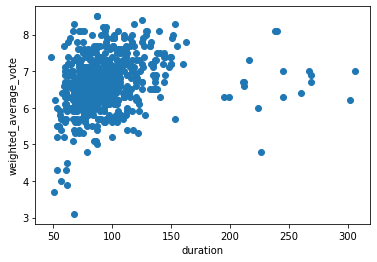

In [566]:
plt.scatter(clustered_df.duration, clustered_df.weighted_average_vote)
plt.xlabel('duration')
plt.ylabel('weighted_average_vote')
plt.show()

In [567]:
X = clustered_df.duration.values.reshape(-1, 1)

In [568]:
X[:5]

array([[ 70],
       [100],
       [120],
       [120],
       [ 55]])

In [569]:
#When we examine the shape of X, we see that there are 693 rows and 1 column:
X.shape

(693, 1)

In [570]:
y = clustered_df.weighted_average_vote

In [571]:
model = LinearRegression()

In [572]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [573]:
y_pred = model.predict(X)
print(y_pred.shape)

(693,)


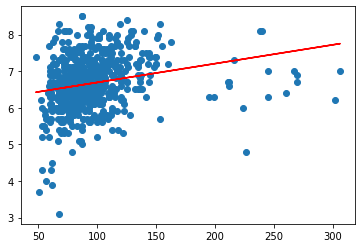

In [574]:
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

In [575]:
print(model.coef_)
print(model.intercept_)

[0.00514726]
6.176904894667942


In [580]:
clustered_df_encoded = pd.get_dummies(clustered_df, columns=["genre1","imdb_title_id","country","language 1","budget",])
clustered_df_encoded

,duration,avg_vote,votes,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,tot_voters_below_30,tot_voters_below_45,tot_voters_above_45,tot_male_voters,tot_female_voters,tot_voters_below_18,PC 1,PC 2,PC 3,Class,genre1_Action,genre1_Adventure,genre1_Animation,genre1_Biography,genre1_Comedy,genre1_Crime,genre1_Drama,genre1_Family,genre1_Fantasy,genre1_Film-Noir,genre1_History,genre1_Horror,genre1_Music,genre1_Musical,genre1_Mystery,genre1_Romance,genre1_Sci-Fi,genre1_Thriller,genre1_Western,imdb_title_id_tt0000574,imdb_title_id_tt0002101,imdb_title_id_tt0002445,imdb_title_id_tt0002452,...,"budget_$950,000","budget_$960,000","budget_$966,000","budget_$971,260","budget_$979,828","budget_$980,000","budget_$99,000","budget_$991,000",budget_DEM 6000000,budget_FIM 933215,budget_FRF 1800000,budget_FRF 20000000,budget_FRF 2100000,budget_FRF 248000,budget_FRF 260000,budget_FRF 5500500,budget_GBP 100000,budget_GBP 12000,budget_GBP 132000,budget_GBP 2000,budget_GBP 20000,budget_GBP 27000,budget_GBP 30000,budget_GBP 300000,budget_GBP 40000,budget_GBP 47000,budget_GBP 47300,budget_GBP 50000,budget_GBP 60000,budget_GBP 600000,budget_GBP 87000,budget_GBP 99000,budget_ITL 45000,budget_NOK 250000,budget_PTE 870000,budget_ROL 400000,budget_SEK 100000,budget_SEK 150000,budget_SEK 180000,budget_SEK 60000
1,70,6.1,589,7.0,7.0,6.1,589,114.0,239.0,115.0,425.0,50.0,0.0,-1.330421,-2.054891,-0.742518,7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100,5.2,446,25.0,3.0,5.2,446,23.0,111.0,193.0,299.0,39.0,23.0,-0.827546,1.809696,-0.231144,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,120,6.2,273,7.0,5.0,6.2,273,34.0,99.0,69.0,191.0,21.0,0.0,-1.214497,2.021091,0.590424,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8,120,6.7,198,4.0,1.0,6.7,198,28.0,104.0,39.0,153.0,19.0,28.0,-0.899990,-1.595735,-0.081692,7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9,55,5.5,225,8.0,1.0,5.5,225,11.0,95.0,72.0,168.0,15.0,11.0,-0.872243,1.967128,-0.292651,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3837,132,6.5,1571,38.0,17.0,6.5,1571,41.0,284.0,862.0,1071.0,136.0,0.0,0.273170,2.077296,0.133121,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3844,64,7.2,116855,173.0,130.0,7.2,116855,27401.0,47335.0,11984.0,63265.0,26746.0,0.0,-0.810981,-1.906799,0.752679,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3858,123,7.3,5750,73.0,49.0,7.3,5750,290.0,1867.0,2450.0,4121.0,549.0,290.0,-1.132206,-2.107007,-0.741397,7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3860,56,5.8,238,8.0,1.0,5.8,238,8.0,27.0,135.0,141.0,40.0,0.0,0.584261,-1.048143,3.829991,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [581]:
y = clustered_df_encoded["weighted_average_vote"]
X = clustered_df_encoded.drop(columns="weighted_average_vote")

In [708]:
#from collections import Counter
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
#Counter(y_train)

In [709]:
##from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=1)
#X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [710]:
#Counter(y_resampled)

In [711]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [627]:
y

1       6.1
3       5.2
7       6.2
8       6.7
9       5.5
       ... 
3837    6.5
3844    7.2
3858    7.3
3860    5.8
3874    7.1
Name: weighted_average_vote, Length: 693, dtype: float64

In [712]:
#Preprocessing the Data for a Neural Network
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print(X_train)

      duration  avg_vote  ...  budget_SEK 180000  budget_SEK 60000
108         48       7.4  ...                  0                 1
3335       105       6.2  ...                  0                 0
1478        70       6.1  ...                  0                 0
1941        69       5.9  ...                  0                 0
783        104       5.8  ...                  0                 0
...        ...       ...  ...                ...               ...
2878        70       6.5  ...                  0                 0
1541        69       6.8  ...                  0                 0
548        118       7.1  ...                  0                 0
210        107       6.6  ...                  0                 0
2440        80       6.0  ...                  0                 0

[519 rows x 1250 columns]


In [713]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train.columns)
hidden_nodes_layer1 = 5000
hidden_nodes_layer2 = 3000
hidden_nodes_layer3 = 1000


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 5000)              6255000   
                                                                 
 dense_22 (Dense)            (None, 3000)              15003000  
                                                                 
 dense_23 (Dense)            (None, 1000)              3001000   
                                                                 
 dense_24 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 24,260,001
Trainable params: 24,260,001
Non-trainable params: 0
_________________________________________________________________


In [714]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [657]:
# Train the model
new_fit_model = nn.fit(X_train_scaled, y_train, epochs=100, shuffle=True)

Epoch 1/100
17/17 [==============================] - 4s 194ms/step - loss: -14179.2920 - accuracy: 0.0000e+00
Epoch 2/100
17/17 [==============================] - 3s 192ms/step - loss: -329264.9375 - accuracy: 0.0000e+00
Epoch 3/100
17/17 [==============================] - 3s 194ms/step - loss: -2741760.2500 - accuracy: 0.0000e+00
Epoch 4/100
17/17 [==============================] - 3s 193ms/step - loss: -13375504.0000 - accuracy: 0.0000e+00
Epoch 5/100
17/17 [==============================] - 3s 194ms/step - loss: -46649044.0000 - accuracy: 0.0000e+00
Epoch 6/100
17/17 [==============================] - 3s 195ms/step - loss: -129666768.0000 - accuracy: 0.0000e+00
Epoch 7/100
17/17 [==============================] - 3s 194ms/step - loss: -307567552.0000 - accuracy: 0.0000e+00
Epoch 8/100
17/17 [==============================] - 3s 199ms/step - loss: -637838656.0000 - accuracy: 0.0000e+00
Epoch 9/100
17/17 [==============================] - 3s 200ms/step - loss: -1210097920.0000 - accur

In [715]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

6/6 - 1s - loss: 0.4533 - accuracy: 0.0000e+00 - 528ms/epoch - 88ms/step
Loss: 0.45326271653175354, Accuracy: 0.0


In [716]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import tensorflow as tf

In [717]:
y = clustered_df_encoded["weighted_average_vote"]
X = clustered_df_encoded.drop(columns="weighted_average_vote")


In [718]:
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [719]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [720]:
# Create the SVM model
svm = SVC(kernel='linear')

In [722]:
# Train the model
#svm.fit(X_train, y_train)

In [674]:
from sklearn import preprocessing
from sklearn import utils

In [675]:
lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform( y_train)

In [676]:
print(utils.multiclass.type_of_target(y_train))
print(utils.multiclass.type_of_target(y_train.astype('int')))
print(utils.multiclass.type_of_target(encoded))

continuous
multiclass
multiclass


In [683]:
clf = LogisticRegression()
clf.fit(X_train,encoded)
print("LogisticRegression")
#print(clf.predict(prediction_data_test))


LogisticRegression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [684]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
   y,  random_state=1)
X_train.shape

(519, 1250)

In [695]:
#Scale and Normalize Data
from sklearn.preprocessing import StandardScaler
data_scaler = StandardScaler()

In [696]:
Imbd_data_scaled = data_scaler.fit_transform(clustered_df_encoded)

In [697]:
Imbd_data_scaled[:5]

array([[-0.73142252, -0.79050581, -0.21813071, ..., -0.0380143 ,
        -0.0380143 , -0.0380143 ],
       [ 0.19913707, -2.06417792, -0.22280938, ..., -0.0380143 ,
        -0.0380143 , -0.0380143 ],
       [ 0.81951012, -0.64898669, -0.22846959, ..., -0.0380143 ,
        -0.0380143 , -0.0380143 ],
       [ 0.81951012,  0.05860893, -0.23092343, ..., -0.0380143 ,
        -0.0380143 , -0.0380143 ],
       [-1.19670231, -1.63962055, -0.23004005, ..., -0.0380143 ,
        -0.0380143 , -0.0380143 ]])

In [698]:
import numpy as np
print(np.mean(Imbd_data_scaled[:,0]))
print(np.std(Imbd_data_scaled[:,0]))

-2.0506283860320352e-16
1.0


In [687]:
model.fit(X_train, y_train)

ValueError: ignored

In [624]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train, y_train)
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)
print(y_train_encoded)
print(utils.multiclass.type_of_target(y_train))
print(utils.multiclass.type_of_target(y_train.astype('int')))
print(utils.multiclass.type_of_target(y_train_encoded))

ValueError: ignored

In [621]:
y_pred = model.predict(X_test)
results = pd.DataFrame({
   "Prediction": y_pred,
   "Actual": y_test
}).reset_index(drop=True)
results.head()

NotFittedError: ignored

In [584]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
   y, random_state=1)

In [608]:
y[:5]

1    6.1
3    5.2
7    6.2
8    6.7
9    5.5
Name: weighted_average_vote, dtype: float64

In [614]:
# Splitting into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78,train_size=0.80)

In [615]:
# Determine the shape of our training and testing sets.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(554, 1250)
(139, 1250)
(554,)
(139,)


In [616]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [617]:
from sklearn.linear_model import LogisticRegression
import numpy as np
classifier = LogisticRegression(solver='lbfgs',
  max_iter=200,
  random_state=1)


In [598]:
X_variables = np.array["weighted_average_vote"]
y_variables = np.array["total_votes"]
u_variables = np.array([i])
lr = LogisticRegression()
lr.fit(x_variables, y_variables)
lr.fit(x_variables, y_variables)
for i in range(20):
   print("x=" + str(i) + " --> " + str(lr.predict_proba([[i]])))

TypeError: ignored

In [ ]:
lab_enc = preprocessing.LabelEncoder()
clustered_df_encoded = lab_enc.fit_transform(y_train)
print(training_scores_encoded)
print(utils.multiclass.type_of_target(y_train)))
print(utils.multiclass.type_of_target(y_train).astype('int')))
print(utils.multiclass.type_of_target(clustered_df_encoded))